# Import and Cleaning

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels
from statsmodels.tsa import stattools
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

plt.rcParams["figure.figsize"] = (12, 6)

In [12]:
df_raw = pd.read_csv("./data/TG_STAID002759.txt", sep=",", header=14)
df = df_raw.drop(" SOUID", axis = 1)

print(df.head())

       DATE     TG   Q_TG
0  18760101     22      0
1  18760102     25      0
2  18760103      3      0
3  18760104    -58      0
4  18760105    -98      0


In [13]:
df["date"] = pd.to_datetime(df["    DATE"], format = "%Y%m%d")
df = df.drop("    DATE", axis = 1)
df.columns = ["temperature", "quality", "date"]
df.set_index("date", inplace = True, drop = True)
df["temperature"] = df["temperature"] / 10
df["timestep"] = range(len(df))
df = df.drop(df[df.quality == 9].index)
month_dummies = pd.get_dummies(df.index.month, drop_first = True, prefix = "month").set_index(df.index)
df = df.join(month_dummies)

print(df.describe())

        temperature  quality      timestep       month_2       month_3  \
count  53527.000000  53527.0  53527.000000  53527.000000  53527.000000   
mean       9.409089      0.0  26865.773273      0.077568      0.085135   
std        7.878684      0.0  15536.326467      0.267494      0.279085   
min      -22.600000      0.0      0.000000      0.000000      0.000000   
25%        3.400000      0.0  13381.500000      0.000000      0.000000   
50%        9.400000      0.0  26958.000000      0.000000      0.000000   
75%       15.800000      0.0  40339.500000      0.000000      0.000000   
max       30.500000      0.0  53721.000000      1.000000      1.000000   

            month_4       month_5       month_6       month_7       month_8  \
count  53527.000000  53527.000000  53527.000000  53527.000000  53527.000000   
mean       0.082276      0.084555      0.081828      0.084555      0.084555   
std        0.274788      0.278222      0.274105      0.278222      0.278222   
min        0.0000

# 

<Axes: xlabel='date'>

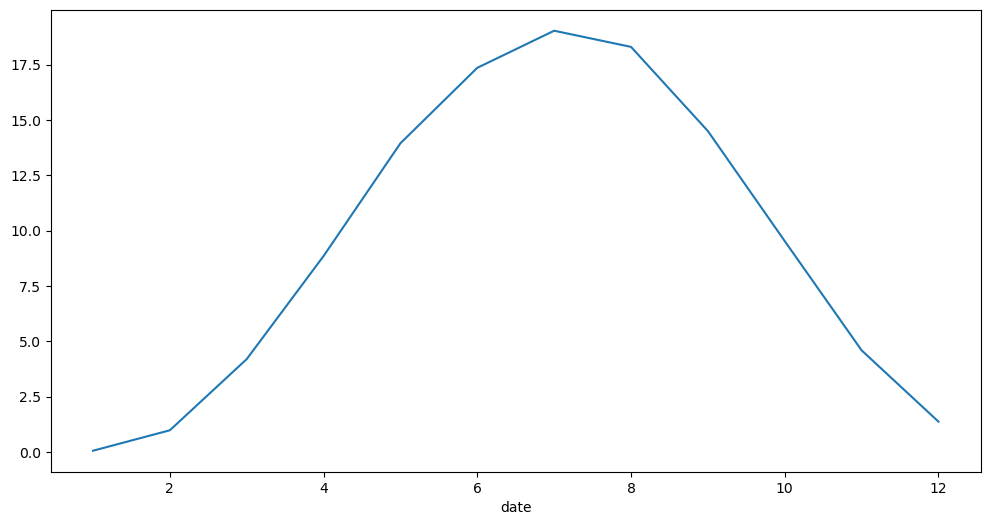

In [14]:
df.groupby(df.index.month)["temperature"].mean().plot()

# Linear Regression Models

In [15]:
y = df["temperature"]
X_months = df.drop(["quality", "temperature"], axis = 1)

m = LinearRegression()
m.fit(X_months, y)
print(m.score(X_months, y))

0.7512299847932467


In [16]:
df["trend_seasonal"] = m.predict(X_months)
df["remainder"] = df["temperature"] - df["trend_seasonal"]
statsmodels.tsa.stattools.adfuller(df["remainder"])

(-23.826173916231916,
 0.0,
 58,
 53468,
 {'1%': -3.4304723089319324,
  '5%': -2.8615940581132935,
  '10%': -2.5667987733323874},
 241115.97124148876)

In [17]:
df["lag1"] = df["remainder"].shift(1)
df.dropna(inplace=True)

<Axes: xlabel='date'>

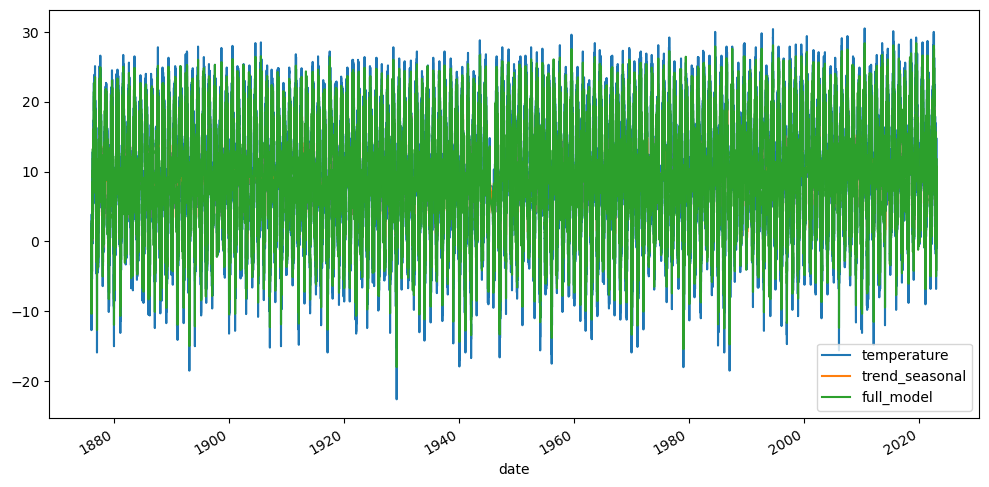

In [18]:
X_full = df.drop(["temperature", "trend_seasonal", "remainder", "quality"], axis=1)
y_full = df["temperature"]
m_full = LinearRegression()
m_full.fit(X_full, y_full)
df["full_model"] = m_full.predict(X_full)
df[["temperature", "trend_seasonal", "full_model"]].plot()

<Axes: xlabel='date'>

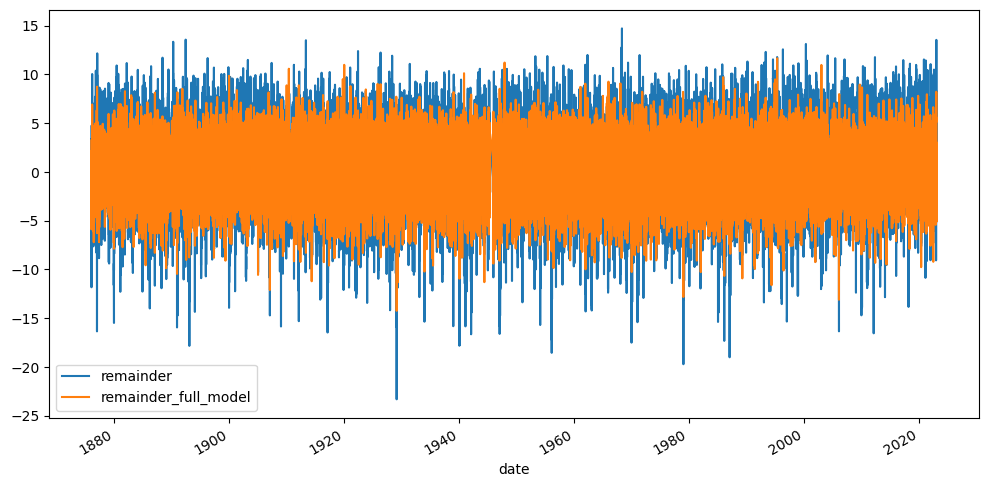

In [19]:
df["remainder_full_model"] = df["temperature"] - df["full_model"]
df[["remainder", "remainder_full_model"]].plot()

In [24]:
ts_split = TimeSeriesSplit(n_splits = 147)
time_series_split = ts_split.split(X_full, y_full)
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)

print(round(result.mean(), 3))

0.908


In [25]:
timestep = df["timestep"].max() + 1
months = [0] * 11
months[0] = 1
lag = df.loc["2023-01-31", "remainder"]

In [26]:
X_future1 = []
X_future1.append(timestep)
X_future1.extend(months)
X_future1.append(lag)

X_future1 = pd.DataFrame([X_future1], columns = X_full.columns)
y_future1 = m_full.predict(X_future1)

print(round(y_future1[0], 1))

4.6


# Export

In [27]:
df["remainder"].to_csv("./output/weather_remainder.csv")
df.to_csv("./output/weather_clean.csv")